<a href="https://colab.research.google.com/github/LisaLi1224/Eddymemory/blob/main/eddymemory(onekernel).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install signalz
import matplotlib.pyplot as plt
import numpy as np
import math
import signalz
from signalz.misc import check_type_or_raise
from signalz.generators.gaussian_white_noise import gaussian_white_noise
from signalz.generators.uniform_white_noise import uniform_white_noise
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
# generate red-noise time series
# source: https://github.com/matousc89/signalz/blob/master/signalz/generators/brownian_noise.py
def brownian_noise(n, leak=0., start=0, std=1., source="gaussian"):
    # check inputs
    check_type_or_raise(n, int, "n")
    check_type_or_raise(leak, float, "leak")
    if not 0. <= leak < 1:
        raise ValueError("Leak must be between 0. and 1.")
    # generate white noise
    if source == "gaussian":
        x = np.random.normal(0, std, n)
    elif source == "uniform":
        x = np.random.uniform(-std / 2., std / 2., n)
    else:
        raise ValueError("Source must be gaussian or uniform")
    # add offset
    x[0] = start
    # integrate the white noise
    for i in range(1, n):
        x[i] += x[i - 1] * (1 - leak)
    return x


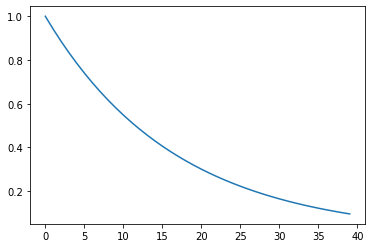

In [80]:
time_interval = 6 # corresponding time interval duration in say days
N_points = 500 # red-noise vector length
tau = 0.2
tspan = np.linspace(0, time_interval, N_points)
dt = tspan[1]-tspan[0]
pre_kernel = np.exp(-tspan/tau) # define pre-defined kernel
kernel_size = 40 # truncate the kernel to include some small number of points since we are assuming it decays with time
pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
tspan_kernel = tspan[:kernel_size]
tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries
plt.plot(pre_kernel)

In [81]:
# red-noise vector length of m_sample
m_sample = 40; 
temp_grad = np.zeros((m_sample,N_points,1))
F_flux = np.zeros((m_sample,N_points - kernel_size + 1,1))
for i in range(m_sample):
  temp_grad[i,:,0] = brownian_noise(N_points, leak=0.1, start=0, std=1, source='gaussian')
  F_flux[i,:,0] = np.convolve(pre_kernel, temp_grad[i,:,0], mode='valid')

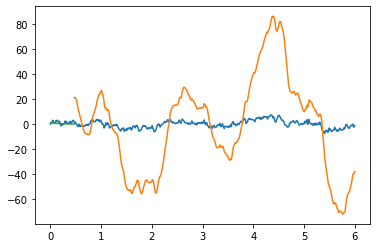

In [82]:
plt.plot(tspan, temp_grad[1,:,0])
plt.plot(tspan_convolved, F_flux[1,:,0])
plt.plot(tspan_kernel, pre_kernel)

In [83]:
# build single layer conv1d model
input_series = keras.layers.Input(temp_grad.shape[1:])
output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
model = keras.Model(input_series, output_series)
model.compile(
    optimizer='adam',
    loss= 'mean_squared_error',
    metrics=['mean_squared_error'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500, 1)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 461, 1)            41        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [84]:
print(new_weights)

[array([[[-1.06625809]],

       [[ 1.2807794 ]],

       [[ 0.77124801]],

       [[ 0.29516126]],

       [[ 1.07721362]],

       [[ 0.63770881]],

       [[ 1.30987817]],

       [[ 0.80450614]],

       [[-0.26644868]],

       [[ 0.03129754]],

       [[ 0.38784463]],

       [[-0.39255976]],

       [[-0.36511083]],

       [[ 0.02938784]],

       [[ 0.52358937]],

       [[-0.66216073]],

       [[-1.16173195]],

       [[ 0.53009536]],

       [[ 0.87673303]],

       [[-0.18217424]],

       [[ 0.38020242]],

       [[-0.3929255 ]],

       [[-0.31573673]],

       [[ 0.0872206 ]],

       [[-0.13194074]],

       [[-1.66675417]],

       [[ 1.55125313]],

       [[ 0.55067858]],

       [[ 1.2906327 ]],

       [[-0.56999874]],

       [[ 0.73924863]],

       [[-0.17602048]],

       [[ 0.37812774]],

       [[-2.03861365]],

       [[-1.09268999]],

       [[-1.51992447]],

       [[-2.76962312]],

       [[-0.03642358]],

       [[-0.45743095]],

       [[ 0.34549088]]])

In [85]:
# split train and test sets
X_train, X_rem, y_train, y_rem = train_test_split(temp_grad,F_flux, train_size=0.8)

In [ ]:
# train the model
model.fit(X_train, y_train, epochs=1000, validation_data = (X_rem, y_rem))

In [87]:
# use model to predict y_rem
y_pred = model.predict(X_rem)

1/1 [==============================] - 0s 51ms/step


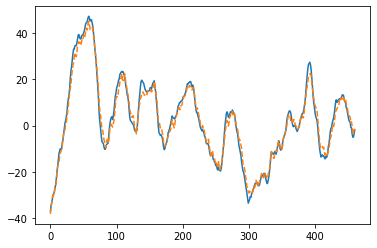

In [88]:
plt.plot(y_rem[2,:,0])
plt.plot(y_pred[2,:,0],'--')

tf.Tensor(
[ 0.07331096  0.01302241  0.14072204  0.19600037  0.19677538 -0.02900015
  0.30090553  0.07692715 -0.03454145  0.12577188  0.2797827   0.3213047
  0.13486941  0.2608306   0.09994182  0.5751297   0.40035707  0.14590426
  0.30083784  0.1997842   0.2749277   0.22413675  0.62349594  0.38989997
  0.6210805   0.37585545  0.35549006  0.33421788  0.7652325   0.7703912
  0.3430812   0.6628403   0.67302287  0.48924553  0.39484876  0.527356
  0.76712555  0.7750374   0.8067688   0.696667  ], shape=(40,), dtype=float32)


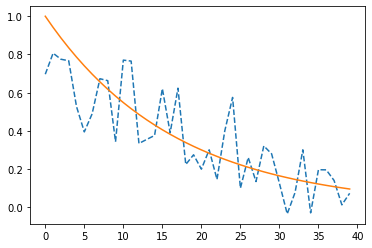

In [89]:
# get the kernel
conv_kernel = model.weights[0][:,0,0]
a = tf.constant(conv_kernel)
conv_kernel = a.numpy()
conv_kernel = conv_kernel[::-1]

plt.plot(conv_kernel,'--')
plt.plot(pre_kernel)
